# DAMA Day Workshop

## Welcome to this DAMA Day Workshop!
If you have any questions about this notebook, please contact us:  
Victoria Da Poian (victoria.dapoian@nasa.gov)  
Eric Lyness (eric.i.lyness@nasa.gov)  

### In this notebook:  
- Processing the Data  
- Exploring the Data   
- Putting data in a ML format  
- Provide some ideas / actions to work on during the workshop (or after :D)  

Data = Csv file with :  
- 1 column for USID (identification of the spectrum)  
- 1950 columns of mass spectra (raw science data)  
- 7 columns for params (parameters linked to the instrument and measurement)  
- 2 columns for labels (6 different categories, 64 samples)  

### Python Environment Setup

#### (1) If you want to run it locally or on a Virtual Machine

In [1]:
#!git clone https://github.com/parksoy/DAMADAY2020_NASA.git

In [2]:
!pwd

/Users/vdapoian/Downloads/DAMADAY2020_NASA-main 2


In [3]:
!ls -lrt #You will see files, as following.

total 249112
-rw-r--r--@ 1 vdapoian  staff  107698487 Oct  8 10:14 ml_data_damaday_final_VDP.csv
-rwxr-xr-x@ 1 vdapoian  staff       9343 Oct 19 13:40 requirements.txt
-rwxr-xr-x@ 1 vdapoian  staff       2341 Oct 19 13:40 README.md
-rwxr-xr-x@ 1 vdapoian  staff       1069 Oct 19 13:40 LICENSE
-rwxr-xr-x@ 1 vdapoian  staff    9017584 Oct 19 16:48 my_model0.h5
-rwxr-xr-x@ 1 vdapoian  staff     598833 Oct 19 16:53 DAMADAY2020WithNASA_workshop_notebook.ipynb


In [2]:
#!pip install -r requirements.txt #This is only needed when you initiate the python environment for the first time.

In [5]:
!which python #This python interpreter is what you will use for this notebook. 

/Users/vdapoian/anaconda3/bin/python


In [6]:
!echo $CONDA_DEFAULT_ENV #this is the name of your Conda Python Environment 

base


In [7]:
from platform import python_version

print(python_version())

3.7.3


#### (2) If you run in Zepl, use "DAMADAY_Python3" image

In [1]:
#!pip install tensorflow==2.3.1 scikit-learn matplotlib optuna pyod #Everytime you instantiate a new image, you need to re-install these following packages or you use custom image "DAMA_Python" in Resorces section

In [9]:
#!pip list

### Getting ready - Snowflake + Zepl connection

In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


#### (1) From Zepl, Download data from Snowflake


In [ ]:
# %python
import snowflake.connector
import hashlib

class SnowflakeDataSource:
    SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

    def init_snowflake(self):
        options = {
            "account": self.account,
            "user": self.user,
            "password": self.password,
            "database": self.database,
            "schema": self.schema,
            "role": self.role,
            "warehouse": self.warehouse,
            "authenticator": self.authenticator,
            "application": self.application
        }

        if self.authenticator == "oauth":
            options["token"] = self.token

        return snowflake.connector.connect(**options)

    def init_snowflake_spark(self):
        sfOptions = {
            "sfURL": "{}.snowflakecomputing.com".format(self.account),
            "sfUser": self.user,
            "sfPassword": self.password,
            "sfDatabase": self.database,
            "sfSchema": self.schema,
            "sfRole": self.role,
            "sfWarehouse": self.warehouse,
            "sfAuthenticator": self.authenticator,
            "application": self.application
        }

        if self.authenticator == "oauth":
            sfOptions["sfToken"] = self.token

        return spark.read.format(self.SNOWFLAKE_SOURCE_NAME).options(**sfOptions)

    def establish_connection(self):
        if self.is_spark():
            df = self.init_snowflake_spark()
            z.addDatasource(self.name, df)
        else:
            con = self.init_snowflake()
            z.addDatasource(self.name, con.cursor())
            z.addDatasource("{}_con".format(self.name), con)

    def is_spark(self):
        try:
            spark
        except NameError:
            return False

        return True

    def __init__(self, name, account, user, password, database, schema, role, warehouse, authenticator, token, clientId, clientSecret, application):
        self.name = name
        self.account = account
        self.user = user
        self.password = password
        self.database = database
        self.schema = schema
        self.role = role
        self.warehouse = warehouse
        self.authenticator = authenticator
        self.clientId = clientId
        self.clientSecret = clientSecret
        self.token = token
        self.application = application


        m = hashlib.md5()
        # We don't include the token since with the current implementation it will change frequently, but it's not necessary to update the connection with new tokens.
        m.update(account.encode('utf8') + user.encode('utf8') + password.encode('utf8') + database.encode('utf8') + schema.encode('utf8') + role.encode('utf8') + warehouse.encode('utf8') + authenticator.encode('utf8')+ clientId.encode('utf8') + clientSecret.encode('utf8') + application.encode('utf8'))
        currentConnectionParamsHash = m.hexdigest()
        try:
            z.getDatasource(name)
        except DatasourceException:
            # Connection doesn't exist, we need to establish a new one.
            self.establish_connection()
            z.add('CONNECTION_PARAMETERS_HASH', currentConnectionParamsHash)
        else:
            # A connection exists, we now check whether any connection parameters have changed since the last connection was established.
            previousConnectionParamsHash = z.get('CONNECTION_PARAMETERS_HASH')
            if currentConnectionParamsHash != previousConnectionParamsHash:
                # Connection parameters have changed, re-establish connection.
                self.establish_connection()
                z.add('CONNECTION_PARAMETERS_HASH', currentConnectionParamsHash)

SnowflakeDataSource(name="DAMA_CSV_parkso3", account="RM42265.west-us-2.azure", user="parkso3", password="Parkso3DAMA", database="NASA_CSV",
                    schema="DAMA_DAY_NASA", role="", warehouse="COMPUTE_WH", authenticator="snowflake", clientId="",
                    clientSecret = "", token="", application="Zepl")

import pandas as pd
# establish connection to Snowflake
cur =z.getDatasource("DAMA_CSV_parkso3")

#cur = z.getDatasource("NASA_CSV")

# execute query
cur = cur.execute('SELECT * FROM dama_nasa_demo_data')# LIMIT 100

# convert datasource into pandas dataframe
dataset = cur.fetch_pandas_all()

# print dataframe as table
z.show(dataset)

#### (2) or Read csv file

In [4]:
import pandas as pd
dataset = pd.read_csv('ml_data_damaday_final_VDP.csv')  
dataset.head(2)

,USID,0,1,2,3,4,5,6,7,8,...,1950,Param1,Param2,Param3,Param4,Param5,Param6,Param7,Label1,Label2
0,8198000001,0,0,0,0,0,0,0,0,0,...,0,12.6549,5,0.463842,1,3812,83,0.01,A,10
1,8198000002,0,0,0,0,0,0,0,0,0,...,0,12.2765,5,0.644139,1,2891,99,0.01,A,10


### Processing and Exploring the Data

### The data we are using in this notebook is csv file

- 1 column for USID (identification of the spectrum)
- 1950 columns of mass spectra (raw science data)
- 7 columns for params (parameters linked to the instrument and measurement)
- 2 columns for labels (6 different categories, 64 samples)

We first have to read in the CSV file that we've been given. We'll use a package called pandas for that:

In [5]:
import pandas as pd
import os
import numpy as np
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
#Read csv
dataset = pd.read_csv('ml_data_damaday_final_VDP.csv')  
dataset.head(2)

,USID,0,1,2,3,4,5,6,7,8,...,1950,Param1,Param2,Param3,Param4,Param5,Param6,Param7,Label1,Label2
0,8198000001,0,0,0,0,0,0,0,0,0,...,0,12.6549,5,0.463842,1,3812,83,0.01,A,10
1,8198000002,0,0,0,0,0,0,0,0,0,...,0,12.2765,5,0.644139,1,2891,99,0.01,A,10


### Analysis of the Columns (USID, Mass Spectra, Parameters, Labels)

In [7]:
###Columns names
columns_names = dataset.columns.tolist()
print(columns_names[-9:])

###Parameters
listAllParams = columns_names[-9:-2]
nberParams = len(listAllParams)
dataset_params = dataset[listAllParams]
print(dataset_params)

###Y values (2 options for the labels)
y_1 = dataset.Label1
y_2 = dataset.Label2

###Define X values (all the dataset, only mass spec data, mass spec data + params)
Xall = dataset.drop(['Label1','Label2'],axis=1) #all data
XnoUSID = Xall.drop(['USID'],axis=1) #all data without USID
XmassSpec = XnoUSID.drop(listAllParams, axis=1) #just mass spec data
print("XmassSpec.shape",XmassSpec.shape)

['Param1', 'Param2', 'Param3', 'Param4', 'Param5', 'Param6', 'Param7', 'Label1', 'Label2']
        Param1  Param2    Param3  Param4  Param5  Param6     Param7
0      12.6549       5  0.463842       1    3812      83   0.010000
1      12.2765       5  0.644139       1    2891      99   0.010000
2      12.7667       5  0.417654       1    2720     102   0.010000
3      12.4442       5  0.712478       1    1961      86   0.010000
4      13.1107       5  0.566622       1    2652      98   0.010000
...        ...     ...       ...     ...     ...     ...        ...
26680  50.5495       1  0.000000       1     767      13  35.279999
26681  50.5172       1  0.000000       1     635      11  35.619999
26682  50.5172       1  0.000000       1     676      13  33.009998
26683  50.5495       1  0.000000       1     757      13  31.400000
26684  50.5172       1  0.000000       1     686      15  31.540001

[26685 rows x 7 columns]
XmassSpec.shape (26685, 1951)


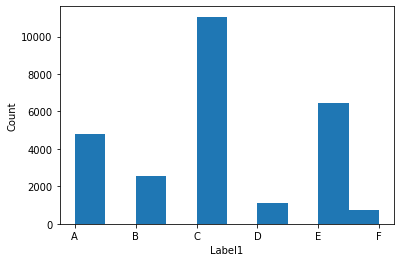

In [8]:
n, bins, patches = plt.hist(dataset.Label1)
plt.xlabel('Label1')
plt.ylabel('Count')
plt.show()

### Define your inputs X and Y

In [9]:
###Here you select the params you want to remove 
listParams = [] #empty = no params to remove
#listParams = ["Param1", "Param2"] #if you want to remove Param1 and Param2


def getRawXy(dataset, listParams, y):  
    X = XnoUSID.drop([param for param in listParams], axis=1)
    inputSize = X.shape[1]
    nb_labels = len(pd.unique(y))
    return X, y, XmassSpec, nb_labels

X, y, XmassSpec, nb_labels = getRawXy(dataset, listParams, y_1)
print("number of labels" , nb_labels)

number of labels 6


### Plot some mass specs

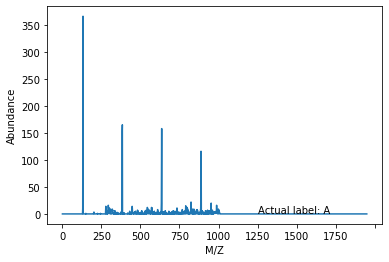

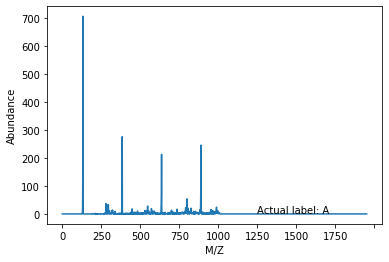

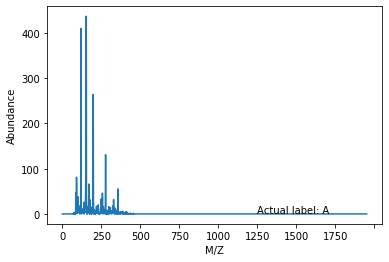

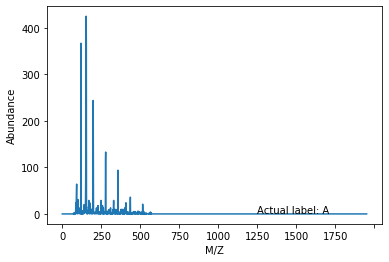

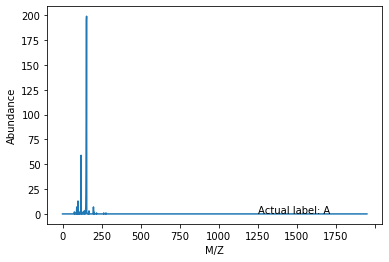

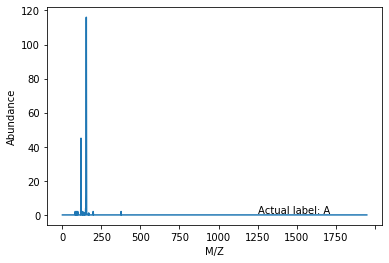

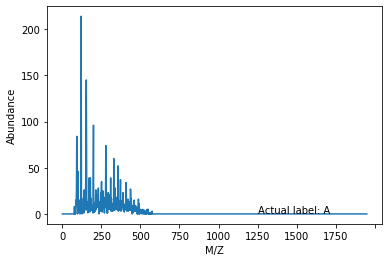

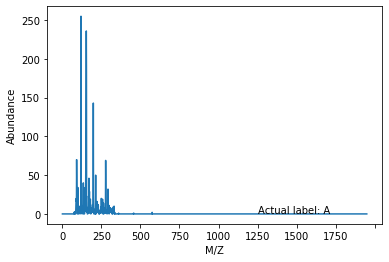

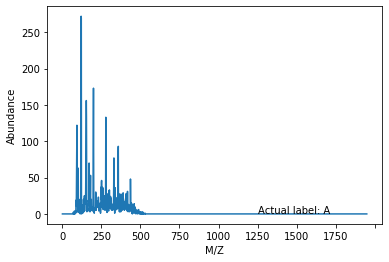

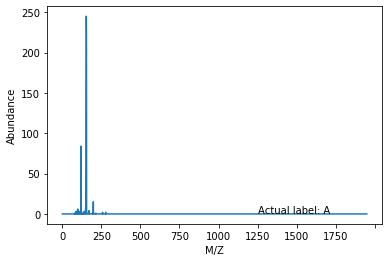

In [10]:
#Mass spec data only
XmassSpec_df = X.drop(['Param1', 'Param2', 'Param3', 'Param4','Param5', 'Param6', 'Param7'], axis=1) 

def plot_oneSpectra(i, XmassSpec_df, y):
    onemassSpec=XmassSpec_df.iloc[i]
    onelabel=y[i]
    plt.text(1250, 1, 'Actual label: {}'.format(str(y[i])))
    ax=onemassSpec.plot()
    ax.set_ylabel('Abundance')
    ax.set_xlabel('M/Z')
    plt.show()
    
for i in range(1,100,10):
    plot_oneSpectra(i, XmassSpec_df, y)

## Processing our data for ML approach

### Encode the labels as integer values

In [12]:
def getLabelEncodedy(y):
    nb_labels = len(pd.unique(y))
    encoder_l = LabelEncoder()
    encoded_y = encoder_l.fit_transform(y)   
    for i in range(nb_labels):
        print(str(i) + " : " + encoder_l.inverse_transform([i]))
    return encoded_y


yencoded=getLabelEncodedy(y)
print(yencoded[10000:10010])
print(y[10000:10010])

['0 : A']
['1 : B']
['2 : C']
['3 : D']
['4 : E']
['5 : F']
[5 5 5 5 5 5 5 5 5 5]
10000    F
10001    F
10002    F
10003    F
10004    F
10005    F
10006    F
10007    F
10008    F
10009    F
Name: Label1, dtype: object


### Let's split the dataset into training, testing sets

In [13]:
###Split dataset ratios
train_test_ratio = 0.2 #80% is used for the training

def preprocess_dataset(dataset, y):
    X, y, XmassSpec, nb_labels = getRawXy(dataset, listParams, y)
    yencoded=getLabelEncodedy(y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, yencoded, test_size=train_test_ratio)
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = preprocess_dataset(dataset, y)
print(X_train.shape, X_test.shape,Y_train.shape, Y_test.shape)

print(Y_train[:10])

['0 : A']
['1 : B']
['2 : C']
['3 : D']
['4 : E']
['5 : F']
(21348, 1958) (5337, 1958) (21348,) (5337,)
[0 2 3 2 3 4 2 2 2 2]


# Classification Approach and Outlier Detection Problem

The purpose of the following is to provide the audience a structure for several tasks / subtasks that could be investigated.  

The following example approaches (TODO part) are provided by   
Soyoung Park, Data Scientist at Lam Research  
Email: soyoung.park.mse@gmail.com

This is only to provide boilerplate codes to facillatate each volunteer to jump on the actual problem easier.  

### Multiclassification Problem 
##### Define your model

In [14]:
# TODO: define your model
#Without manual feature engineering/dimentionlity reduction  
#Main reference: https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2c
        
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Reshape,BatchNormalization
from tensorflow.keras.layers import MaxPooling1D, UpSampling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#X_train: (21348, 1958)
#Y_train: (21348, )
n_spectrastep=X_train.shape[1]
num_sensors=1
output_classes=to_categorical(Y_train).shape[1]

def baseline_model(output_classes):
    #Simplest 1 layer 1DCNN
    model0 = models.Sequential()
    model0.add(Reshape((n_spectrastep, num_sensors), input_shape=(n_spectrastep,)))
    model0.add(Conv1D(filters=64, kernel_size=10, activation='relu')) 
    model0.add(Flatten()) 
    model0.add(Dense(output_classes,  activation='softmax'))
    model0.summary()
    return model0

model0=baseline_model(output_classes)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1958, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1949, 64)          704       
_________________________________________________________________
flatten (Flatten)            (None, 124736)            0         
_________________________________________________________________
dense (Dense)                (None, 6)                 748422    
Total params: 749,126
Trainable params: 749,126
Non-trainable params: 0
_________________________________________________________________


##### Train the model

In [26]:
# TODO: train the model

BATCH_SIZE=32
SEED=42

#https://shrikar.com/deep-learning-with-keras-and-python-for-multiclass-classification/ 
def compile_fit(model, EPOCHS):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit([X_train], 
                            batch_size=BATCH_SIZE, 
#                             y=to_categorical(Y_train), \
                            y=to_categorical(Y_train), \
                            verbose=1, \
                            validation_split=0.25, 
                            shuffle=True, 
                            epochs=EPOCHS, 
                            ) 

    return history

history0=compile_fit(model0, EPOCHS=3)  

Epoch 1/3
501/501 [==============================] - 13s 27ms/step - loss: 0.2655 - accuracy: 0.9330 - val_loss: 0.3734 - val_accuracy: 0.9067
Epoch 2/3
501/501 [==============================] - 15s 31ms/step - loss: 0.1802 - accuracy: 0.9521 - val_loss: 0.3178 - val_accuracy: 0.9155
Epoch 3/3
501/501 [==============================] - 17s 33ms/step - loss: 0.1221 - accuracy: 0.9636 - val_loss: 0.6823 - val_accuracy: 0.8973


##### Evalulate the model

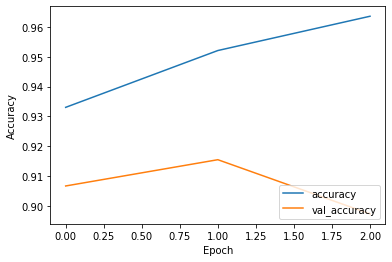

In [27]:
# TODO: evaluate the model. 
#plot accuracy, loss during training and validation
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
     
plot_history(history0)

# loss, acc = model0.evaluate(X_test,  to_categorical(Y_test), verbose=2)
# print('Model, accuracy: {:5.2f}%'.format(100*acc))

In [28]:
loss, acc = model0.evaluate(X_test,  to_categorical(Y_test), verbose=2)
print('Model 0 accuracy: {:5.2f}%'.format(100*acc))

#Looking at some predictions
y_pred=model0.predict_classes(X_test)
print(y_pred[:10])
print(Y_test[:10])

167/167 - 1s - loss: 0.8301 - accuracy: 0.8934
Model 0 accuracy: 89.34%
[4 2 2 4 4 2 4 1 2 2]
[4 2 2 4 4 4 4 1 2 2]


[[[4356   12]
  [  27  942]]

 [[4825   12]
  [ 152  348]]

 [[2974  164]
  [ 169 2030]]

 [[5096   13]
  [  38  190]]

 [[3699  356]
  [ 130 1152]]

 [[5166   12]
  [  53  106]]]


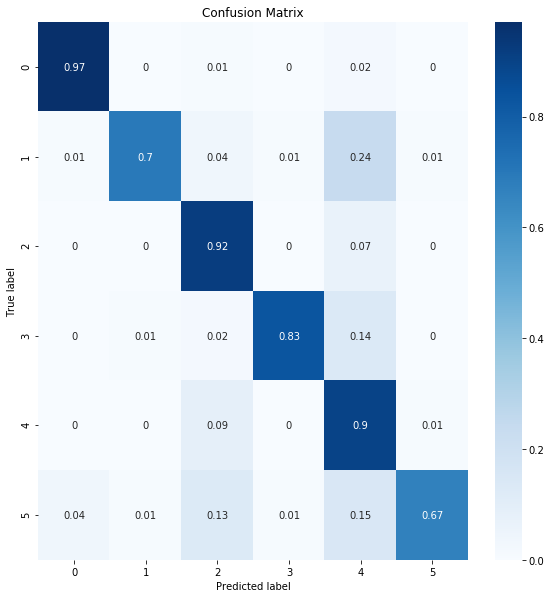

In [29]:
# TODO: plot confusion-matrix for multi-class classification
#Precision,recall, ROC, Confution matrix, F2 score are major parameters 
#to measure the accuracy of the classifier.
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
#ROC,AUC for multiclass
#https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
    
#(1) text
from sklearn.metrics import multilabel_confusion_matrix
#detail math is here:https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-confusion-matrix
print(multilabel_confusion_matrix(Y_test, y_pred))

#TrueClass (axis=0) vs. False class (axis=1)
#TP, FP
#FN, TN
# True Positive (TP): the number of predictions where the classifier correctly predicts the positive class as positive.
# True Negative (TN): the number of predictions where the classifier correctly predicts the negative class as negative.
# False Positive (FP): the number of predictions where the classifier incorrectly predicts the negative class as positive.
# False Negative (FN): the number of predictions where the classifier incorrectly predicts the positive class as negative.

#(2) Better visualization of confusion matrix
#https://androidkt.com/keras-confusion-matrix-in-tensorboard/

con_mat = tf.math.confusion_matrix(labels=Y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm)


import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

##### Save the model (HDF5 file) and retrieve it

In [19]:
#TODO:  Save the entire model after training to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model0.save('my_model0.h5') 
! ls -lrt

total 248216
-rw-r--r--@ 1 soyoungpark  staff       1069 Oct  6 19:00 LICENSE
-rw-r--r--  1 soyoungpark  staff       2341 Oct  7 09:37 README.md
-rw-r--r--@ 1 soyoungpark  staff  107698487 Oct  8 15:13 ml_data_damaday_final_VDP.csv
-rw-r--r--  1 soyoungpark  staff       9343 Oct 16 12:08 requirements.txt
-rw-r--r--@ 1 soyoungpark  staff     585237 Oct 19 16:17 DAMADAY2020WithNASA_workshop_notebook.ipynb
-rw-r--r--  1 soyoungpark  staff    9017584 Oct 19 16:18 my_model0.h5


In [20]:
#TODO: retrieve the model

#!ls {checkpoint_dir}
# Recreate the exact same model, including its weights and the optimizer
pretrained_model = tf.keras.models.load_model('my_model0.h5')

# Show the model architecture
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1958, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1949, 64)          704       
_________________________________________________________________
flatten (Flatten)            (None, 124736)            0         
_________________________________________________________________
dense (Dense)                (None, 6)                 748422    
Total params: 749,126
Trainable params: 749,126
Non-trainable params: 0
_________________________________________________________________


In [62]:
#TODO: confirm, pretrained model is performaing the same way as when it was trained.
loss, acc = pretrained_model.evaluate(X_test,  to_categorical(Y_test), verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

167/167 - 1s - loss: 0.5311 - accuracy: 0.9149
Restored model, accuracy: 91.49%


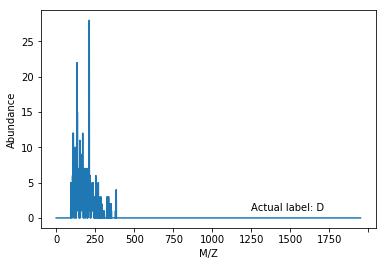

For sample i = 3778 predicted Label [0 1 2 3 4 5]: 2
For sample i = 3778 actual Label [0 1 2 3 4 5]: 2
Accuracy score over the whole Y_test set: 0.9149334832302792


In [67]:
#TODO:infer a class/label for a random Xtest data
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score,f1_score,cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

XmassSpec_df=X_test.drop(['Param1', 'Param2', 'Param3', 'Param4','Param5', 'Param6', 'Param7'], axis=1) 

# plot one test sample spectra
i=np.random.randint(len(X_test))
plot_oneSpectra(i, XmassSpec_df, y)
    
# Infer with the pre-trained model    
predicted = pretrained_model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
 
print("For sample i =", i, "predicted Label {}:".format(np.unique(yencoded)), predicted[i])
print("For sample i =", i, "actual Label {}:".format(np.unique(yencoded)), Y_test[i]) ##added by Vic
print("Accuracy score over the whole Y_test set:", accuracy_score(Y_test, predicted))   # accuracy: (tp + tn) / (p + n)

##### Improve model (architecture, hyperparameters tuning, ...)

In [ ]:
# TODO: improve model  

def build_improved_model(output_classes):
    model1= models.Sequential()
    model1.add(Reshape((n_spectrastep, num_sensors), input_shape=(n_spectrastep,)))
    model1.add(BatchNormalization())
    model1.add(Conv1D(filters=256, kernel_size=3, activation='relu', \
                    input_shape=(n_spectrastep,num_sensors))) 
    model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', \
                    input_shape=(n_spectrastep,num_sensors))) 
    model1.add(BatchNormalization())
    model1.add(Dropout(0.5))
    model1.add(Flatten()) 
    model1.add(Dense(output_classes, activation='softmax'))   
    model1.summary()
    return model1

model1=build_improved_model(output_classes)
history1=compile_fit(model1, EPOCHS=3) #Check if model runs or not with EPOCHS=1 first, then, increase EPOCHS.
plot_history(history1)

In [69]:
# TODO: Optimize Hyperparameters
# good starting point: https://towardsdatascience.com/hyper-parameters-optimization-c2f888515d8f

# (1) define hyperparameters you want to optimize
class Args:
    
    #learning
    BATCH_SIZE=[32,64]
    EPOCHS=3
    
    #1DCNN
    NumFilter1DCNN1=[128,256]
    NumFilter1DCNN2=[64,32]
    KERNEL_SIZE=[3,10]
    
    #Misc
    DROPOUTRATE=[0.2,0.5]
    
args=Args()

# (2) parameterize all hyperparameters 
def build_improved_model_parameterized(output_classes):
    model2= models.Sequential()
    model2.add(Reshape((n_spectrastep, num_sensors), \
                       input_shape=(n_spectrastep,)))
    model2.add(BatchNormalization())
    model2.add(Conv1D(filters=args.NumFilter1DCNN1, \
                      kernel_size=args.KERNEL_SIZE, \
                      activation='relu', \
                    input_shape=(n_spectrastep,num_sensors))) 
    model2.add(Conv1D(filters=args.NumFilter1DCNN2, \
                      kernel_size=args.KERNEL_SIZE, \
                      activation='relu', \
                    input_shape=(n_spectrastep,num_sensors))) 
    model2.add(BatchNormalization())
    model2.add(Dropout(args.DROPOUTRATE))
    model2.add(Flatten()) 
    model2.add(Dense(output_classes, activation='softmax'))   
    model2.summary()
    return model2

#(3) train the model with many different combination of hyperparameters either 
# (a) with simple grid search for loop/ distributed spark jobs (one combination-onerun/one node)
# (b) with commercial open source packages or 
#     There are many Hyperparameter optimization methodology, one of them 
#     I was personally interested in trying was https://optuna.org/


### Anomaly Detection Problem

(60000, 28, 28)
(10000, 28, 28)
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0239 - val_loss: 0.0133


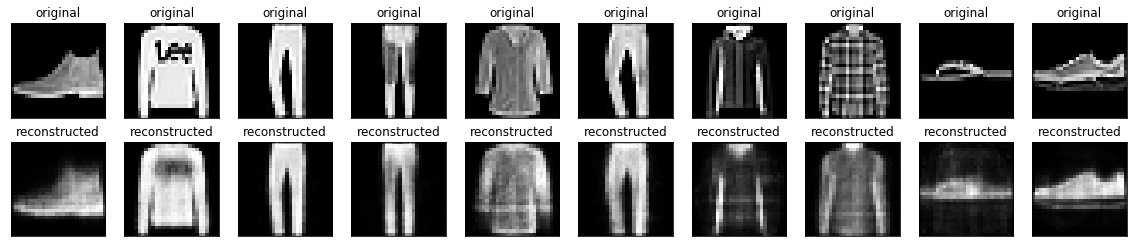

In [23]:
# TODO: In reality, labeling each spectrum is very expensive(or difficult) 
# and potentially can miss outlier. Instead of classification approach, we can have a 
# learner to learn about the spectra dataset within itself.
# Before we jump into outlier detection approach with our dataset, 
# let's review an example of encoder-decoder for 2D images 
# to get a sense of how it works and how it can be applied for 
# outlier detection.

#The boilerplate code are from 
#https://www.datatechnotes.com/2020/03/convolutional-autoencoder-example-with-keras-in-python.html
#https://blog.keras.io/building-autoencoders-in-keras.html
#https://www.tensorflow.org/tutorials/generative/autoencoder

#  define your model
#X_train: (21348, 1958) is input and output.
 
n_spectrastep=X_train.shape[1]
num_sensors=1
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Soyoung needs to change the dimension to 1d spectra
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape) #(60000, 28, 28)
print (x_test.shape)

latent_dim = 64 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.Flatten(),
                                            layers.Dense(latent_dim, activation='relu'),
                                           ])
        self.decoder = tf.keras.Sequential([layers.Dense(784, activation='sigmoid'),
                                            layers.Reshape((28, 28))
                                           ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim) 

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=1,
                shuffle=True,
                validation_data=(x_test, x_test))

encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Idea is that, when there is an outlier you never have seen in the 
# test set, the learner did not learn about it yet. Therefore, 
# it will give very different reconstructed image from the original, 
# and we can detect those by taking difference between the original 
# image and the reconstruted image. 

501/501 [==============================] - 2s 3ms/step - loss: 41775.3478 - val_loss: 46074.9807


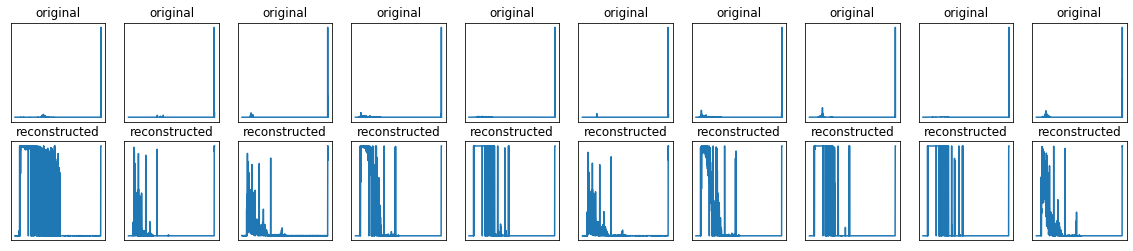

In [24]:
# TODO: Now, change Input/model to 1d Spectrum for outlier detection

#  define your model
#X_train: (21348, 1958) is input and output.
 
n_spectrastep=X_train.shape[1]
num_sensors=1
 
# Soyoung changed the dimension to 1d spectra from the 2D example above.
latent_dim = 64 
tf.keras.backend.set_floatx('float64') #Later if you need very high precision, recommend this.

# Fully connected Dense layer based autoencoder
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim     
        self.encoder = tf.keras.Sequential([
                                            layers.Dense(64, 
                                                         activation='relu',
                                                         input_shape=(n_spectrastep,)),#(64,1)
                                            layers.Dense(latent_dim, 
                                                         activation='relu')
                                           ])
        self.decoder = tf.keras.Sequential([layers.Dense(n_spectrastep, 
                                                         activation='sigmoid'),#(1958,1)
                                        
                                           ])

        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# If you want to use 1DCNN encoder-decoder, 
#https://blog.keras.io/building-autoencoders-in-keras.html
#A quick example:
#model3 = models.Sequential()
#model3.add(Reshape((n_spectrastep, num_sensors), input_shape=(n_spectrastep,)))
#model3.add(Conv1D(filters=1, kernel_size=200)) 
#model3.add(MaxPooling1D(10))
#model3.add(Conv1D(filters=1, kernel_size=200)) 
#model3.add(MaxPooling1D(10))...

autoencoder = Autoencoder(latent_dim=2) 
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x=np.array(X_train), y=np.array(X_train),
                epochs=1,
                shuffle=True,
                validation_split=0.25
               )

encoded_spectrum = autoencoder.encoder(np.array(X_test)).numpy()
decoded_spectrum = autoencoder.decoder(encoded_spectrum).numpy()

#Plot original spectrum-reconstructed spectrum
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    X_test.iloc[i].plot()
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(decoded_spectrum[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#We only trained 1 Epoch, and the architecture is very primitive, and 
#hyperparameters are not optimized, so the original and reconstructed
#look very different since the learner didn't learn very well yet. 

TODO: From here, we can go in two different ways:  
Path (1) Improve the model. Once reached some level of low average MSE, find a test spectra with high MSE; That should be an outlier that doesn't quite belong to any of classes/case we never have seen.    
Path (2) Improve the model. Once reached some level of low average MSE,  take the extracted feature, you can apply further outlier detection algorithms in the following cells.     

In [25]:
#TODO: Path(2) Extracted feature (Rank 2) can go into the following outlier detection
encoded_spectrum

array([[0.00000000e+00, 2.62935554e+02],
       [7.79960927e+01, 9.63563856e+00],
       [4.24845108e+01, 8.60300982e+00],
       ...,
       [0.00000000e+00, 1.08676252e+03],
       [0.00000000e+00, 1.41620766e+03],
       [1.77073555e+03, 1.87983820e+04]])

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Feature Bagging
Model 4 Histogram-base Outlier Detection (HBOS)
Model 5 Isolation Forest
Model 6 K Nearest Neighbors (KNN)
Model 7 Average KNN
Model 8 Local Outlier Factor (LOF)
Model 9 Minimum Covariance Determinant (MCD)
Model 10 One-class SVM (OCSVM)
Model 11 Principal Component Analysis (PCA)


/Users/vdapoian/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


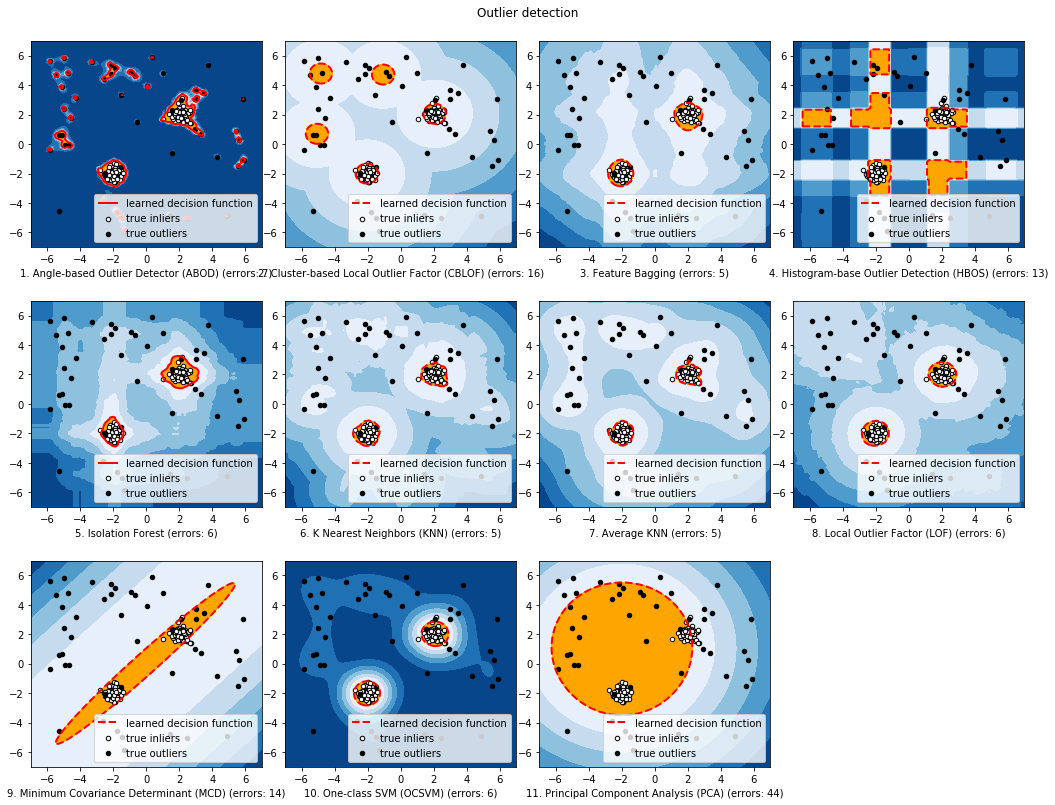

In [84]:
#TODO: Now apply pyod outlier detection algorithms on the encoded feature

# TODO: Following is direct copy of
# https://github.com/yzhao062/pyod/blob/master/notebooks/Compare%20All%20Models.ipynb
# so input is *NOT* our dataset. This is just to show you an example 
# of variety of outlier detection algorithms out there. 

from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

#Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [2] #Soyoung adds comments: You can manually fix the number of clusters

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]


random_state = np.random.RandomState(42)
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
#     'Locally Selective Combination (LSCP)': LSCP(
#         detector_list, contamination=outliers_fraction,
#         random_state=random_state)  #Soyoung commented out- not working due to dimension
}


# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)
    
# Fit the models with the generated data and 
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 12))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        #print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()

# Now, we will need to adapt input from the example code to our encoded rank2 features.
# (not included in this notebook)
    

### Other ideas for classification / detection

In [ ]:
#TODO:

# Artifical Data Generation

The purpose of the following is to provide the audience a structure for several tasks / subtasks that could be investigated for the generation of artificial data to increase the volume of our dataset.

How can we make more data? Transfer learning is still a big question mark, how is it implementable? What is the best way?  

In [ ]:
#TODO:

### Artificial Data Generation

In [ ]:
#TODO:

## References

TODO:
###### Deep learning boiler plate codes :
https://www.datacamp.com/community/tutorials/cnn-tensorflow-python
https://www.tensorflow.org/guide/keras/sequential_model  
https://www.tensorflow.org/tutorials/images/cnn  
https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/  
https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/  
https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/  

For outlier detection approach, there are various approaches out there people have already solved and published out. Starting from reading review papers on anomaly detection methodologies:

###### Machine learning based:
[review of machine learning approaches](https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/)

    Outlier Detection and Removal  
    Dataset and Performance Baseline  
     -  House Price Regression Dataset  
     -  Baseline Model Performance  
    Automatic Outlier Detection  
     -  Isolation Forest  
     -  Minimum Covariance Determinant  
     -  Local Outlier Factor  
     -  One-Class SVM  

[anomaly-detection-algorithm-from-scratch](https://towardsdatascience.com/a-complete-anomaly-detection-algorithm-from-scratch-in-python-step-by-step-guide-e1daf870336e)

[Overview of outlier detection methods in sklearn](https://scikit-learn.org/stable/modules/outlier_detection.html)


###### Deep learning based:

[DEEP LEARNING FOR ANOMALY DETECTION: A SURVEY](https://arxiv.org/pdf/1901.03407.pdf)

[pyod Python library](https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/). Especially, check out their interactive Jupyter notebook https://pyod.readthedocs.io/en/latest/

 
###### Summary above: 
Various approaches from simple to complex order:
[Univariate Outlier detection -statistically](https://towardsdatascience.com/a-complete-anomaly-detection-algorithm-from-scratch-in-python-step-by-step-guide-e1daf870336e)  

Feature extraction, then, visualize clusters to see how distribution looks like.
Deep Anomaly Detection/Feature extraction references  

[Unsupervised Anomaly Detection in Multivariate SpatioTemporal Datasets using Deep Learning](https://project.inria.fr/aaltd19/files/2019/08/AALTD_19_Karadayi.pdf)  
[how to build autoencoder](https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/)  
[CNN-LSTM Encoder-Decoder based anomaly detection](https://www.mdpi.com/2076-3417/10/15/5191/pdf)    
[VGG-16 net->PCA clustering-> feature vector for turbine blades failure detection](https://www.mdpi.com/2076-3417/10/15/5191/pdf)  
[Traditional models review](https://www.sciencedirect.com/science/article/pii/S2590198220300233)  
Their main claim: traditional models often fail to fully capture complex structures in the data    
 - using parametric and non-parametric statistical models, 
 - data clustering, 
 - rule-based systems, 
 - mixture models, 
 - and SVMs (Support Vector Machines)
 
[Unsupervised Anomaly Detection in Multivariate
Spatio-Temporal Data Using Deep Learning: Early
Detection of COVID-19 Outbreak in Italy](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9187620)  

###### Data Augmentation
Augment data with simulation generating mass spectra. 
http://physics.bu.edu/~duffy/HTML5/mass_spectrometer.html  

Data Augmentation-Domain specific1  
https://venturebeat.com/2020/10/08/the-secrets-of-small-data-how-machine-learning-finally-reached-the-enterprise/amp/  

Data Augmentation-Domain specific2  
https://www.youtube.com/watch?v=vbhEnEbj3JM  

#### End of example approaches by Soyoung Park (TODO part)!